## Models

In this section we are going to apply different models to our data in search of the best classifier. We are facing a 3 class classification problem with the diagnosis of Alzheimer being the response variable and which can be Normal (NL), Mild Cognitive Impairment (MCI) or Dementia/Alzheimer's Disease (AD). But first we need a systematic approach to apply the different models so we are going to group some functions together:

In [0]:
### Functions for pre-processing ###

def fit_model(model, model_name: str, ADNI_df: pd.DataFrame, to_OHE: list, non_pred: list, sparse: list, viscode_select='m12',truth='DX', graphviz_plot=False):
  
  X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)
  
  #fit model
  model = model.fit(X_train,y_train)
  
  #generate predicted values
  y_pred = model.predict(X_test)
  
  #generate plots to assess performance metrics
  make_model_plots(y_test,y_pred,model_name)
  
  if graphviz_plot:
    dot_data=export_graphviz(model, out_file=None) 


    dot_data_sized=edit_dot_string(dot_data,(15,18))

    graph = graphviz.Source(dot_data_sized)
    display(graph)
  
  return model, accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)

def make_model_plots(y_test,y_pred,model_name: str):
  
  print('The accuracy of %s is %g\n' % (model_name, accuracy_score(y_test,y_pred)))
  
  #calculate confusion matrix and make plot
  confusion = confusion_matrix(y_test,y_pred)
  plt.figure(0)
  ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
  ax.set_title('%s Classifier: Confusion Matrix' % model_name);
  ax.set_xlabel('Predicted class');
  ax.set_ylabel('True class');
  
  #make plot of real vs predicted class counts
  plot_df=pd.DataFrame([y_test],index=['Class']).T
  plot_df['Value Type']='True'


  plot_df2=pd.DataFrame([y_pred],index=['Class']).T
  plot_df2['Value Type']='Predicted'

  plot_df_final=plot_df.append(plot_df2)
  plot_df_final.tail()
  
  plt.figure(1)
  ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
  ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
  ax2.set_title('%s: True vs Predicted Values' % model_name);
  
  
def edit_dot_string(dot_data, size: tuple):
  
  import io
  
  newline=""
  
  s = io.StringIO(dot_data)
  for i, line in enumerate(s):
    
    if i==1:
      newline=newline + """\n ratio="fill";\nsize="%g,%g!";\n""" % size 
    
    else:
      newline=newline+line
  
  return newline

### Logistic Regression (Base Model)

We are going to start applying one of the most simple classification models and we are going to use it as our base model: Logistic Regression. From there we will try different models, including one that has not been seen during class.

The accuracy of Logistic Regression CV is 0.85473



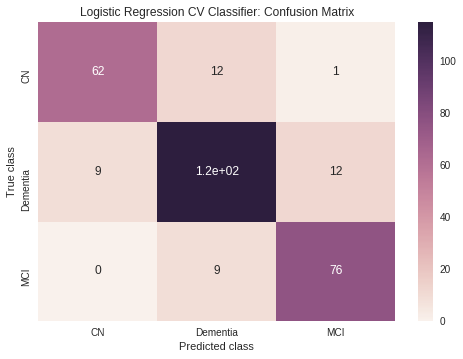

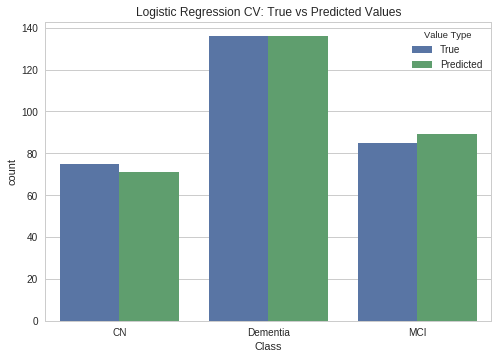

In [0]:
#Fit a Logistic Regression
logregcv = LogisticRegressionCV(Cs=10, cv=5, penalty='l2',solver='lbfgs', max_iter=1000, n_jobs=-1)

logregcv, logregcv_acc, logregcv_conf = fit_model(logregcv, 'Logistic Regression CV', ADNI_df, to_OHE, non_pred, sparse)

### KNN


The accuracy of KNN is 0.726351



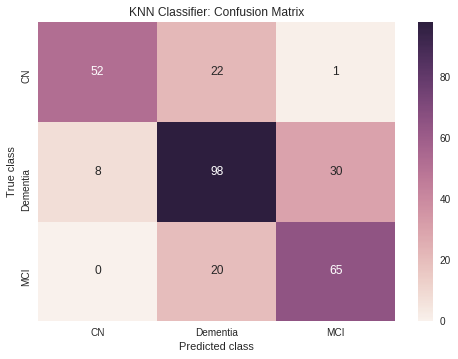

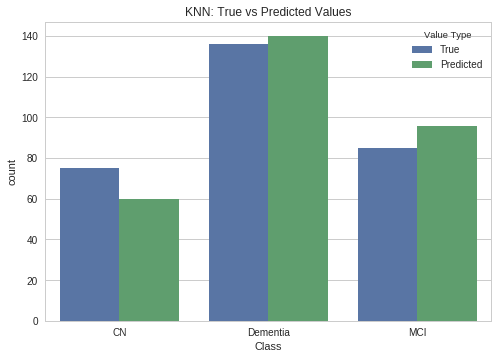

In [0]:
#Fit KNN Regression
knn = KNeighborsClassifier(n_neighbors=5)  

knn, knn_acc, knn_conf = fit_model(knn, 'KNN', ADNI_df, to_OHE, non_pred, sparse)

### LDA

The accuracy of LDA is 0.766892



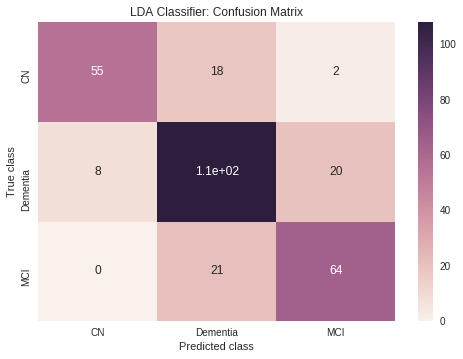

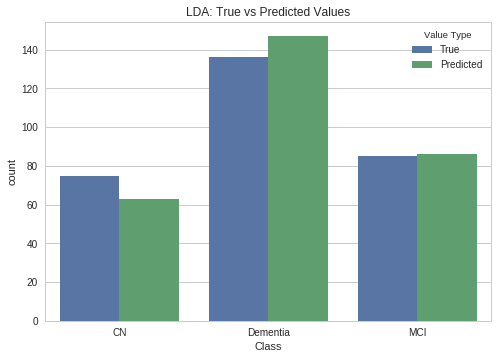

In [0]:
#Fit LDA Classifier
LDA = LinearDiscriminantAnalysis()

LDA, LDA_acc, LDA_conf = fit_model(LDA, 'LDA', ADNI_df, to_OHE, non_pred, sparse)

### QDA

The accuracy of QDA is 0.405405



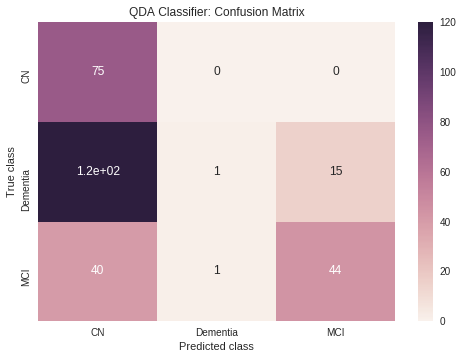

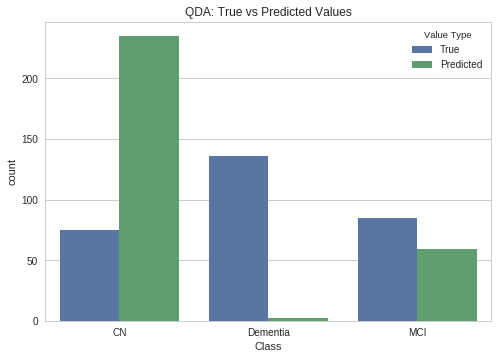

In [0]:
#Fit QDA Classifier
QDA = QuadraticDiscriminantAnalysis()

QDA, QDA_acc, QDA_conf = fit_model(QDA, 'QDA', ADNI_df, to_OHE, non_pred, sparse)

### Decision Trees

Decision Trees are comprised of a nested series of comparisons between predictors that are compared to threshold values.  Each decision, or split, involves a single feature and a threshold value that separates the classes.  The "tree" takes an upside down appearance with the root class at the top, and subsequent branches and nodes becoming more "pure" for a specific class as we move down.  

Here we will fit a simple decision tree model to our data and stop it at a max depth of 10 to help mitigate overfitting.  We'll then graph what the tree looks like and plot the summary of the performance.

The accuracy of Decision Tree: MaxDepth=10 is 0.847973



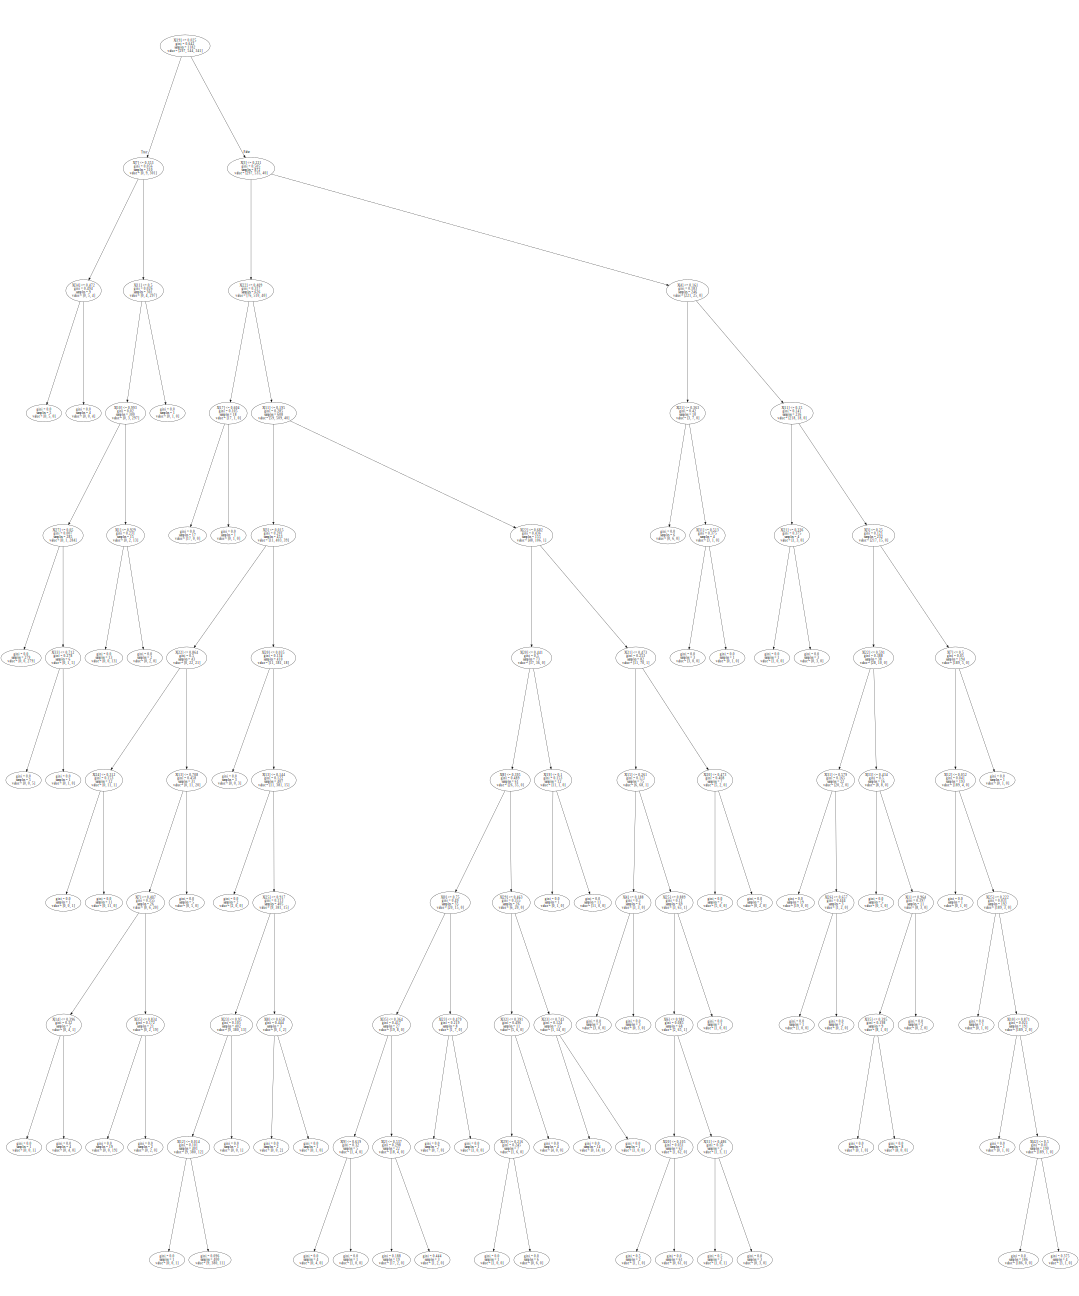

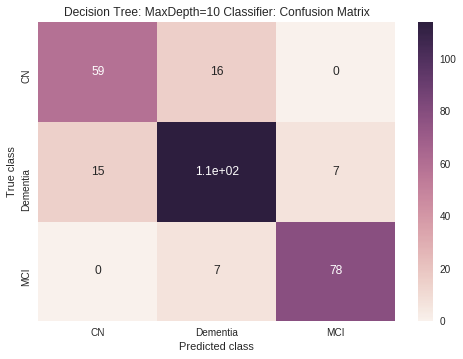

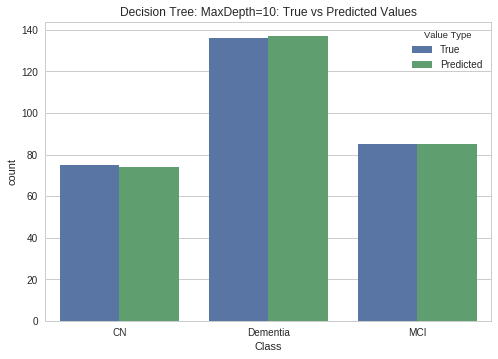

In [0]:
#lets try again with a less overfit tree
clf10 = DecisionTreeClassifier(max_depth=10)

clf10, clf10_acc, clf10_conf = fit_model(clf10, 'Decision Tree: MaxDepth=10', ADNI_df, to_OHE, non_pred, sparse, graphviz_plot=True)


### Random Forest

The decision trees performed fairly well at classification, but let's see if we can do better using a random forest.  This combines random combinations of decision trees along with random subsets of predictors to create an ensemble model with increased predictive value over any of the base simple models.  

The accuracy of Random Forest is 0.888514



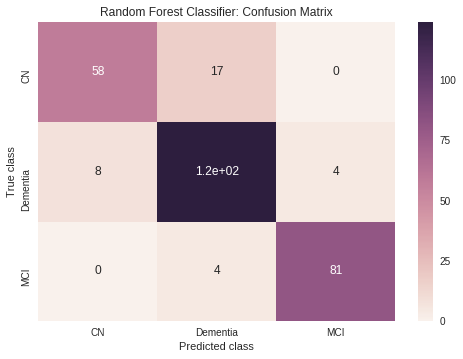

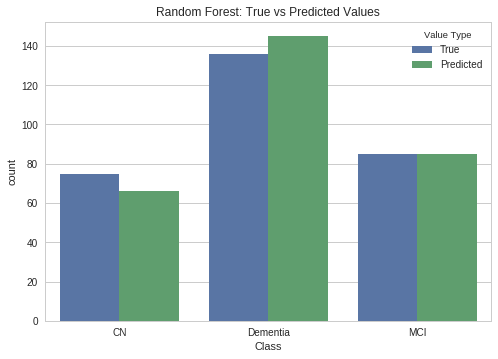

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(n_estimators=100, max_depth=None)
rf_model, rf_model_acc, rf_model_conf = fit_model(rf_model, 'Random Forest', ADNI_df, to_OHE, non_pred, sparse)

### Neural Network



In addition to traditional regression types, we also investigated two simple neural networks.  Multi-Layer-Perceptrons known as (MLPs) use forward propagation and automatic differentiation in order to learn weights between connected node models.  This approach can be useful when working with complication correlations.

#### Preprocessing

Some slight preprocessing is required to build out a connected neural network on our data.  One of the main design choices we made was to one hot encode our three classes of DX's, use Min-Max Scalar to put all of our data in the range of [0,1] and fillna with a mean imputation.

In [0]:
viscode_select='m12'
truth='DX'

#Take only one year visits and DXs with non-NaN values
ADNI_selected = ADNI_df.loc[ADNI_df['VISCODE'] == viscode_select]
ADNI_selected = ADNI_selected.dropna(subset = [truth])

#Define predictors and output
y = ADNI_selected[truth]
X = ADNI_selected.drop(sparse,axis = 1)
X = X.drop(non_pred,axis = 1)

#Replace NaNs in non-categorical data
X_float=X.drop(to_OHE,axis=1)
X_float = X_float.fillna(X_float.mean())

scaled_values = MinMaxScaler().fit_transform(X_float)
X_float = pd.DataFrame(scaled_values, index=X_float.index, columns=X_float.columns)

#One hot encode where necessary
X_cat = pd.get_dummies(X[to_OHE])
y = pd.get_dummies(y)

X = pd.concat([X_float,X_cat], axis=1)

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Once our data has been preprocessed appropriately, we first used a very simple fully connected NN using keras.

#### MLP

We selected an appropriate input shape and several hidden layers of various dense sizes, and an output into 3 classes to predict the different Dxs:

In [0]:
inp = Input(shape = (X_train.shape[1],))
x = Dense(200, activation='relu')(inp)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='sigmoid')(x)

model = Model(inputs=inp, outputs= x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 53)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               10800     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 387       
Total params: 42,865
Trainable params: 42,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs = 20, validation_split=0.2)


Train on 945 samples, validate on 237 samples
Epoch 1/20
945/945 [==============================] - 1s 611us/step - loss: 0.0848 - acc: 0.8720 - val_loss: 0.0780 - val_acc: 0.8945
Epoch 2/20
945/945 [==============================] - 0s 75us/step - loss: 0.1066 - acc: 0.8402 - val_loss: 0.1212 - val_acc: 0.8143
Epoch 3/20
945/945 [==============================] - 0s 84us/step - loss: 0.0991 - acc: 0.8550 - val_loss: 0.1115 - val_acc: 0.8228
Epoch 4/20
945/945 [==============================] - 0s 77us/step - loss: 0.0956 - acc: 0.8529 - val_loss: 0.0948 - val_acc: 0.8565
Epoch 5/20
945/945 [==============================] - 0s 81us/step - loss: 0.0702 - acc: 0.8984 - val_loss: 0.1008 - val_acc: 0.8439
Epoch 6/20
945/945 [==============================] - 0s 70us/step - loss: 0.0771 - acc: 0.8857 - val_loss: 0.0940 - val_acc: 0.8565
Epoch 7/20
945/945 [==============================] - 0s 75us/step - loss: 0.0828 - acc: 0.8783 - val_loss: 0.1063 - val_acc: 0.8397
Epoch 8/20
945/945 [==

The accuracy of Neural Network is 0.858108



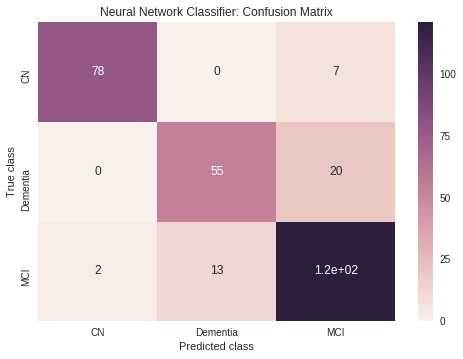

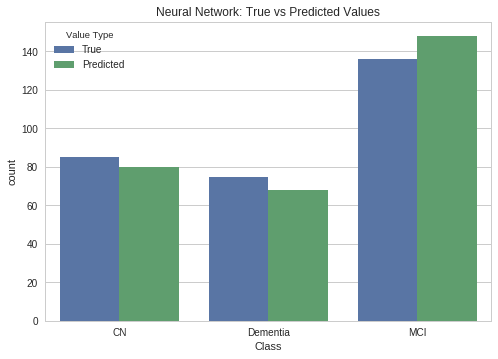

In [0]:
#generate accuracy score
NN_acc = model.evaluate(X_test, y_test)[1]

#get probabilities and make class predictions for NN
y_proba_nn = model.predict(X_test)
y_pred_nn = y_proba_nn.argmax(axis=-1)

NN_conf = confusion_matrix(y_test.values.argmax(axis=-1),y_pred_nn)


make_model_plots(y_test.values.argmax(axis=-1),y_pred_nn,'Neural Network')

Our Neural Network once trained created a decently accurate model to predict our patient DX.  This could be a useful tool, however due to the lack of interpretability of NNs, very little information can be passed back to the physician regarding the importance of the different predictors.

### SVM

Support Vector Machines seek to separate date by constructing optimal hyperplanes.  Hyperplanes are n-dimensional separators that are placed to maximize the distance between the decision boundary (the hyperplane) and the classes.  The data points closest to the decision boundary are called support vectors and they are what determine the position and orientation of the hyperplane.  The distance of the support vectors to the decision boundary is minimized using a cost function.


Let's fit a simple Support Vector Classifier and see how it performs on our data. 

The accuracy of SVM is 0.868243



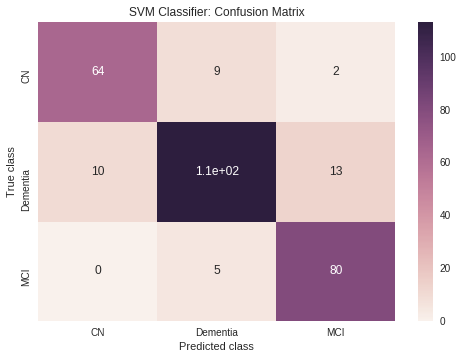

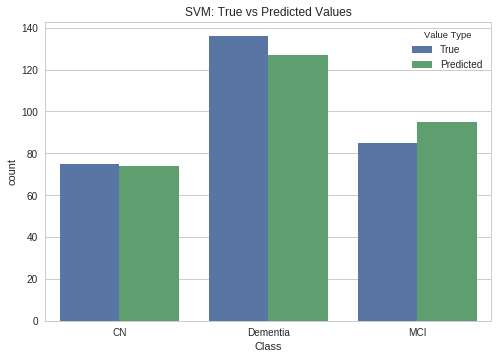

In [0]:
svc = LinearSVC(C=100, dual=False, class_weight='balanced', max_iter=10000, random_state=42)
svc, svc_acc, svc_conf = fit_model(svc, 'SVM', ADNI_df, to_OHE, non_pred, sparse)

Perhaps we can do better by tuning our C penalty parameter using GridSearchCV.

The accuracy of SVM - GridSearch Optimized is 0.868243



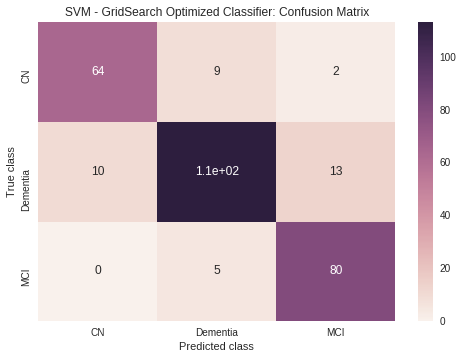

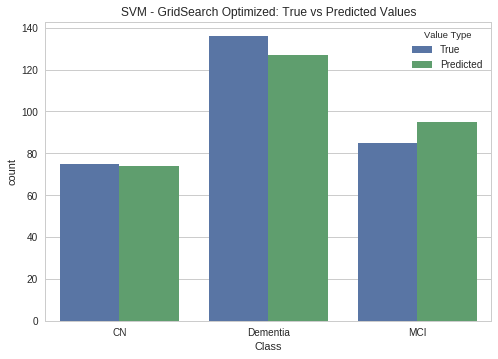

In [0]:
# Classification with a linear SVM, optimizing C using GridSearchCV
svc_grid = LinearSVC(dual=False, random_state=42, class_weight='balanced')
params_grid = {"C": [10**k for k in range(-3, 4)]}
svc_grid = GridSearchCV(svc_grid, params_grid)

svc_grid, svc_grid_acc, svc_grid_conf = fit_model(svc_grid, 'SVM - GridSearch Optimized', ADNI_df, to_OHE, non_pred, sparse)

### Dimensionality Reduction Exploration: UMAP

Since we are dealing with a large number of features, it may be helpful to explore dimensionality reduction techniques to aid in both visualization and improving the performance of one of our models.  The UMAP method produces similar results to the PCA method we learned in class, but goes about reducing dimensions in a very different way.  Most dimension reduction techniques fall into two camps: matrix factorization (like PCA) and neighbor graphs (like UMAP).  UMAP is a manifold method that takes into account local relationships between neighboring points while preserving the overall global structure of the data.  More information can be found in the cited paper in the **Literature** section.

First, let's use UMAP to reduce all of our dimensions down to 2 for easy plotting and take a look at our data.  2-dimensional data is easily plotted and interpreted by people, so it's a sensible starting point

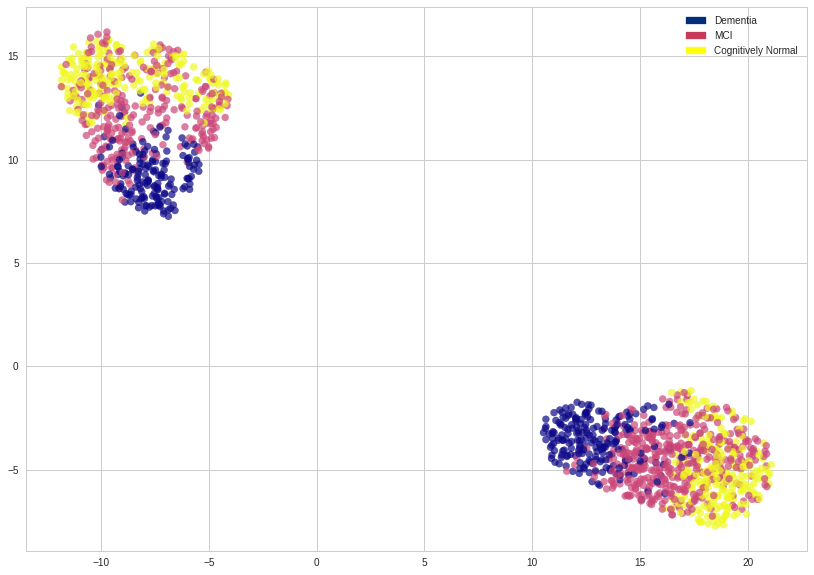

In [0]:
def plot_umap(ADNI_df: pd.DataFrame, to_OHE, non_pred, sparse):
  
  #obtain our training and test data as usual
  X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)
  
  #stack all available data together for embedding and visualization
  data=np.vstack([X_train,X_test])
  target=np.hstack([y_train,y_test])
  embedding=UMAP(random_state=42, n_components=2,n_neighbors=500,min_dist=1,metric='braycurtis').fit_transform(data)
  
  fig, ax = plt.subplots(1, figsize=(14, 10))
  ax.scatter(*embedding.T, c=target, cmap='plasma',alpha=0.7)
  
  #insert patches for legend
  blue_patch = mpatches.Patch(color='#002f7c', label='Dementia')
  red_patch = mpatches.Patch(color='#c6395a', label='MCI')
  yellow_patch = mpatches.Patch(color='#ffff0c', label='Cognitively Normal')
  plt.legend(handles=[blue_patch,red_patch,yellow_patch])
  
plot_umap(ADNI_df, to_OHE, non_pred, sparse)

UMAP grouped the data into 2 clusters and the data points for each class are grouped together within each of the clusters.  We'll see if this helps one of the classifiers we worked with earlier.  We will now try to use UMAP and GridSearchCV to improve on the Support Vector Classifier model we fit previously.


SVM accuracy on the test set with raw data: 0.868
SVM accuracy on the test set with UMAP transformation: 0.713
The accuracy of UMAP-Reduced SVM is 0.712838



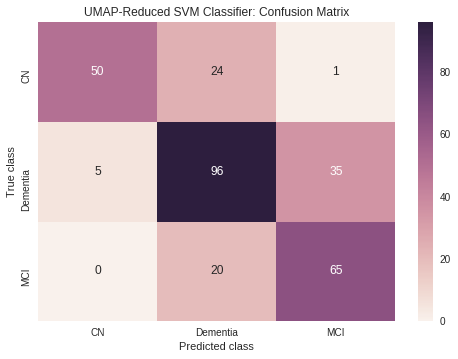

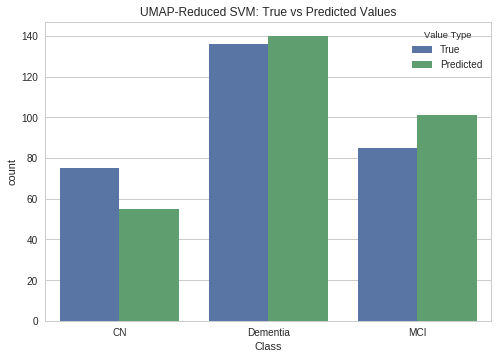

In [0]:
def svc_Umap(ADNI_df: pd.DataFrame, to_OHE, non_pred, sparse):
  X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)

  # Classification with a linear SVM, as done before
  svc_grid_umap = LinearSVC(dual=False, random_state=42, class_weight='balanced')
  params_grid = {"C": [10**k for k in range(-2, 3)]}
  clf = GridSearchCV(svc_grid_umap, params_grid, cv=5, n_jobs=-1)
  clf.fit(X_train, y_train)

  # Transform with UMAP followed by SVM classification using pipeline
  umap = UMAP(random_state=4242, metric='minkowski', min_dist=0.5)
  pipeline = Pipeline([("umap", umap),
                     ("svc", svc_grid_umap)])
  params_grid_pipeline = {"umap__n_neighbors": [20,500],
                        "umap__n_components": [5, 10],
                        "svc__C": [10**k for k in range(-2, 3)]}

  clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline, cv=5, n_jobs=-1)
  clf_pipeline.fit(X_train, y_train)

  print("\nSVM accuracy on the test set with raw data: {:.3f}".format(
    clf.score(X_test, y_test)))

  print("SVM accuracy on the test set with UMAP transformation: {:.3f}".format(
    clf_pipeline.score(X_test, y_test)))
  
  #generate predictions from the UMAP reduced SVM for plotting
  y_pred = clf_pipeline.predict(X_test)
  
  make_model_plots(y_test,y_pred,'UMAP-Reduced SVM')
  
  return clf_pipeline.score(X_test, y_test), confusion_matrix(y_test,y_pred)




UMAP_svc_acc, UMAP_svc_conf = svc_Umap(ADNI_df, to_OHE, non_pred, sparse)


It seems that UMAP made things a bit worse for prediction in this specific case.  UMAP is usually used when there are thousands to tens of thousands predictors.  When we initially started on the project, it appeared that we would at least have thousands of predictors to model with.  But due to knowledge of the data, practical concerns and limitations of the dataset structure, we ended up with fewer predictors than we initially anticipated, making UMAP unnecessary for this specific application.  It is, however, a very useful technique for true high-dimensionality problems that arise in DNA and RNA sequencing applications for which this method was initially developed for.